In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import ruptures as rpt
import time

In [2]:
base_url = 'https://www.speedrun.com/api/v1/games'
game_name = 'elden_ring'

response = requests.get(f'{base_url}?name={game_name}')
data = response.json()

# The game ID should be in the returned data
game_id = data['data'][0]['id']
game_id

'nd28z0ed'

In [4]:
base_url = 'https://www.speedrun.com/api/v1/runs'
status = 'verified'
category = 'Any_Glitchless-PC'
orderby = 'date'
direction = 'desc'
max_results = 200  # Maximum results per page

# Creating an empty list to store the extracted data
extracted_data = []

# Fetching each page of results
page = 0
while True:
    offset = page * max_results
    response = requests.get(f'{base_url}?game={game_id}&status={status}&category={category}&orderby={orderby}&direction={direction}&max={max_results}&offset={offset}')
    
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()

        # If 'data' is an empty list, we've fetched all the results
        if not data['data']:
            break

        # Extracting the fields from each run and add them to the list
        for run in data['data']:
            date = run['date']
            submitted = run['submitted']
            verified = run['status']['status']
            primary_t = run['times']['primary_t']
            realtime_t = run['times']['realtime_t']
            extracted_data.append([date, submitted, verified, primary_t, realtime_t])

        # Printing a message to show the progress
        print(f'Page {page + 1} processed.')
    else:
        print(f'Request failed with status code {response.status_code}. Stopping data collection.')
        break

    # Pause the loop for 0.6 seconds to ensure the rate of requests stays below 100 per minute
    time.sleep(0.6)
    
    # Increment the page number
    page += 1
    
# Converting the list to a DataFrame
df = pd.DataFrame(extracted_data, columns=['Date', 'Submitted', 'Verified', 'Primary_t', 'Realtime_t'])
df

Page 1 processed.
Page 2 processed.
Page 3 processed.
Page 4 processed.
Page 5 processed.


,Date,Submitted,Verified,Primary_t,Realtime_t
0,2024-02-15,2024-02-15T21:26:23Z,verified,3476,3476
1,2024-02-10,2024-02-11T04:44:28Z,verified,9386,9386
2,2024-02-07,2024-01-29T12:37:27Z,verified,4530,4530
3,2024-02-01,2024-02-01T05:16:17Z,verified,3417,3417
4,2024-01-28,2024-01-28T09:41:58Z,verified,10170,10170
...,...,...,...,...,...
964,2022-03-20,2022-03-25T06:09:10Z,verified,1644,1644
965,2022-03-20,2022-03-25T15:05:08Z,verified,10114,10114
966,2022-03-18,2022-03-25T19:21:57Z,verified,3780,3780
967,2022-03-18,2022-03-27T22:39:38Z,verified,1715,1715


In [5]:
# Save the DataFrame to a CSV file

df.to_csv('eldenring_speedrun_data.csv', index=False)
df

,Date,Submitted,Verified,Primary_t,Realtime_t
0,2024-02-15,2024-02-15T21:26:23Z,verified,3476,3476
1,2024-02-10,2024-02-11T04:44:28Z,verified,9386,9386
2,2024-02-07,2024-01-29T12:37:27Z,verified,4530,4530
3,2024-02-01,2024-02-01T05:16:17Z,verified,3417,3417
4,2024-01-28,2024-01-28T09:41:58Z,verified,10170,10170
...,...,...,...,...,...
964,2022-03-20,2022-03-25T06:09:10Z,verified,1644,1644
965,2022-03-20,2022-03-25T15:05:08Z,verified,10114,10114
966,2022-03-18,2022-03-25T19:21:57Z,verified,3780,3780
967,2022-03-18,2022-03-27T22:39:38Z,verified,1715,1715


In [6]:
# Load the data from the CSV file into a new df
csv_df = pd.read_csv('eldenring_speedrun_data.csv')

/tmp/ipykernel_2611/3355883690.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(pd.to_datetime(csv_df['Date']), csv_df['Top_Score'], linestyle='solid', marker=None)


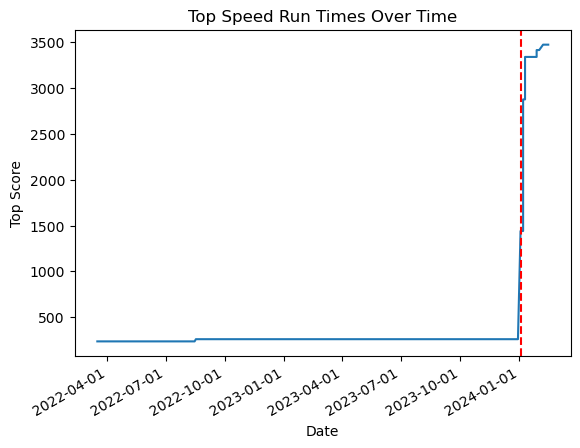

In [11]:
csv_df['Top_Score'] = csv_df['Realtime_t'].cummin()

# Convert the 'Top_Score' series to a numpy array
data = csv_df['Top_Score'].values

# Define a change point detection model
model = "l2"  # "l2" model uses the sum of squared errors as the cost function
algo = rpt.Pelt(model=model).fit(data)

# Detect the change point
result = algo.predict(pen=99999999)  # "pen" is the penalty value, adjust as needed

# The change point is the index of the first element in the result
change_point = result[0]

# Convert the change point index to a date
efficiency_date = csv_df.iloc[change_point]['Date']

# Create a new figure and axes
fig, ax = plt.subplots()

# Plot the top scores
ax.plot_date(pd.to_datetime(csv_df['Date']), csv_df['Top_Score'], linestyle='solid', marker=None)

# Add a vertical line at the point of efficiency
ax.axvline(x=pd.to_datetime(efficiency_date), color='red', linestyle='--')

# Set the title and labels
ax.set_title('Top Speed Run Times Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Top Score')

# Format date
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Rotate date labels automatically
fig.autofmt_xdate()

# Show the plot
plt.show()